<a class="anchor" id="0.1"></a>
# **Table of Contents**

1.	[Introduction](#1)
   - 1.1.[Setup environment](#1.1)
   - 1.2 [Import packages](#1.2)
   - 1.3 [Import data](#1.3)        
2.	[Data preprocessing](#2)
   - 2.1.[Characteristics](#2.1)
   - 2.2 [Interests](#2.2)
   - 2.3 [Mail response](#2.3)
   - 2.4 [Neighborhood](#2.4)
   - 2.5 [Promotion and Gift](#2.5)       
3.	[Data cleanning](#3)
   - 3.1 [Outliers](#3.1)
   - 3.2 [Missing values](#3.2)
   - 3.3 [Data transformation](#3.3)
   - 3.4 [Dimensionality reduction](#3.4)       
4. [Clustering](#4)

# **1. Introduction** <a class="anchor" id="1"></a>

## **1.2. Import packages** <a class="anchor" id="1.2"></a>

In [1]:
# Remember: library imports are ALWAYS at the top of the script, no exceptions!
import math
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from math import ceil
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from pandas_profiling import ProfileReport
from sklearn.cluster import AgglomerativeClustering, KMeans,DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
# Feature selection
from sklearn.feature_selection import VarianceThreshold

from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances

from sklearn import random_projection

from scipy.cluster.hierarchy import dendrogram
from scipy import stats

from collections import Counter

#Functions
import OurFunctions as func

## **1.3. Import data** <a class="anchor" id="1.3"></a>

In [2]:
data = pd.read_csv('donors.csv',index_col='CONTROLN', low_memory=False)
print("The data set has total %d records and %d features" %data.shape)

The data set has total 95412 records and 475 features


# **2. Pre-processing data:** <a class="anchor" id="2"></a>

After conducting **Exploratory Data Analysis (Appendix 1)** for 475 features of the original data set, we have listed out the most significant features that we consider to be important for the clustering task.  
Thus, from now, we will continue with these selected features:

In [3]:
# Import the database we create for selecting the features:
selected_features_list = pd.read_csv('Selected_Features.csv',index_col=0)
selected_features_list.head()

,FeaturesName,Description,Category,Selected
Index,,,,
1,ODATEDW,Origin Date. Date of donor's first gift,Characteristics,x
2,OSOURCE,Origin Source,Characteristics,x
3,TCODE,Donor title code,Characteristics,x
4,STATE,State abbreviation (a nominal/symbolic field),Characteristics,x
5,ZIP,Zipcode (a nominal/symbolic field),Characteristics,x


In [4]:
# function to update slected features dataframe everytime we adjust the data
def update_selected_feats_list(df, features_list):
    selected_feats = features_list.loc[features_list['FeaturesName'].isin(df.columns),:]
    return selected_feats

# Get the selected features
selected_feats = selected_features_list[selected_features_list['Selected'] == 'x']['FeaturesName']
df = data[selected_feats].copy()

Next step, we will access each features subset by goinf through 3 steps:
- A) Feature engineering
- B) Unique values check
- C) Correlation check

## **2.1. Characteristics:** <a class="anchor" id="2.1"></a>


In [5]:
char_feats = selected_features_list[selected_features_list['Category'] == 'Characteristics']['FeaturesName']

### **A) Feature engineering:**

In [6]:
selected_features_list[selected_features_list['Category'] == 'Characteristics']

,FeaturesName,Description,Category,Selected
Index,,,,
1,ODATEDW,Origin Date. Date of donor's first gift,Characteristics,x
2,OSOURCE,Origin Source,Characteristics,x
3,TCODE,Donor title code,Characteristics,x
4,STATE,State abbreviation (a nominal/symbolic field),Characteristics,x
5,ZIP,Zipcode (a nominal/symbolic field),Characteristics,x
6,MAILCODE,Mail Code,Characteristics,x
8,DOB,"Date of birth (YYMM, Year/Month format.)",Characteristics,x
14,MDMAUD,The Major Donor Matrix code,Characteristics,x
15,DOMAIN,DOMAIN/Cluster code. A nominal or symbolic field.,Characteristics,x


#### **Getting the Age of every donor:**

We notice that there is one feature called DOB - Day of Birth of the donors, so we thought it would we useful to generate the age of the donors as one feature. The donor's age will be measured at the time the donor received the most recent promotion which is recorded in 'MAXADATE' feature.

In [7]:
df['DOB'].head()

CONTROLN
95515     1957-12-01
148535    1972-02-01
15078            NaN
172556    1948-01-01
7112      1940-01-01
Name: DOB, dtype: object

<AxesSubplot:>

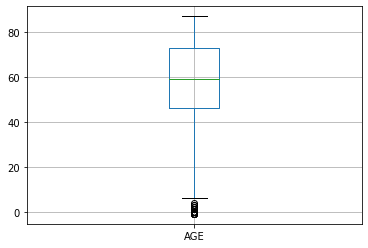

In [8]:
#converting the DOB column to datetime type
parsed_dates = pd.to_datetime(df.DOB, format='%Y-%m-%d' , errors='coerce') #errors='coerce' meant to return NaN in case of exception
df['DOB'] = parsed_dates
df['MAXADATE'] = pd.to_datetime(df['MAXADATE'], format='%Y-%m-%d' , errors='coerce')
# Getting the age of every donor today
df['AGE'] = ((df['MAXADATE'] - df['DOB']).dt.days/365).floordiv(other=1).astype('int',errors='ignore')

# Append new features to the feature list metatada
feats = pd.DataFrame([['AGE', "Age of the donor","Characteristics","x" ]],
                    columns=selected_features_list.columns)
selected_features_list= selected_features_list.append(feats,ignore_index=True)

# Now, drop de DOB column as it is no longer useful
df.drop('DOB',inplace=True,axis = 1)
# After deleting some columns, we need to update the selected features list:
selected_features_list = selected_features_list.loc[selected_features_list['FeaturesName'].isin(df.columns),:]
# Get the new list of characteristics features
char_feats = selected_features_list[selected_features_list['Category'] == 'Characteristics']['FeaturesName']

# Check for the box plot and distribution
df.boxplot(['AGE'])
# Here we can see that we have outliers, we will access this in the up coming session

#### **Converting NaN values:**

There are some columns contain missing values but in different type of format rather than NaN format. Thus, in this section, we will replace them with numpy.NaN values for better processing:

In [9]:
df[char_feats].isin([' ']).sum(axis = 0)

ODATEDW         0
OSOURCE       928
TCODE           0
STATE           0
ZIP             0
MAILCODE    94013
MDMAUD          0
DOMAIN       2316
HOMEOWNR    22228
CHILD03     94266
CHILD07     93846
CHILD12     93601
CHILD18     92565
NUMCHLD         0
INCOME          0
GENDER       2957
WEALTH1         0
HIT             0
MAJOR       95118
WEALTH2         0
GEOCODE     80168
GEOCODE2      187
AGE             0
dtype: int64

In [10]:
# Except for MAILCODE where ' ' is actually a value, we will replace all other ' ' values as NaN
for col in df[char_feats].isin([' ']).sum(axis = 0).index:
    if col == 'MAILCODE':
        next
    else:
        df[col] = df[col].replace(' ', np.NaN)

#### **Converting gender values:**

In [11]:
#checking all the values for the Gender
#M = Male
#F = Female
#U = Unknown
#J = Joint Account
print(df['GENDER'].unique())

['F' 'M' nan 'C' 'U' 'J' 'A']


There are some values that is not described in the metadata, we will assume that these values are Unknown(U) values

In [12]:
#replacing unknown values to 'U'
df['GENDER'].replace(' ','U',inplace=True)
df['GENDER'].replace('A','U',inplace=True)
df['GENDER'].replace('C','U',inplace=True)

#checking the difference
print(df['GENDER'].unique())

['F' 'M' nan 'U' 'J']


#### **Converting invalid ZIP values:**

In [13]:
#clean all the ZIP values with hifén
df.ZIP = df.ZIP.replace("-","", regex=True)

In [14]:
# After deleting some columns, we need to update the selected features list:
selected_features_list = selected_features_list.loc[selected_features_list['FeaturesName'].isin(df.columns),:]
# Get the new list of characteristics features
char_feats = selected_features_list[selected_features_list['Category'] == 'Characteristics']['FeaturesName']

### **B) Unique values check:**

In [15]:
# Check for top frequency values
df[char_feats].describe(include=['O'])

,ODATEDW,OSOURCE,STATE,ZIP,MAILCODE,MDMAUD,DOMAIN,HOMEOWNR,CHILD03,CHILD07,CHILD12,CHILD18,GENDER,MAJOR,GEOCODE,GEOCODE2
count,95412,94484,95412,95412,95412,95412,93096,73184,1146,1566,1811,2847,92455,294,15244,95093
unique,54,895,57,16488,2,28,16,2,3,3,3,3,4,1,7,4
top,2015-01-01,MBC,CA,85351,,XXXX,R2,H,M,M,M,M,F,X,12,A
freq,15358,4539,17343,64,94013,95118,13623,52354,869,1061,1149,1442,51277,294,3914,34484


In [16]:
# Check for the percentage of the top unique value
func.unique_check_categorical(df[char_feats], 0.9)

MAILCODE , percentage of top unique value = 98.53 %
MDMAUD , percentage of top unique value = 99.69 %
MAJOR , percentage of top unique value = 100.00 %


In [17]:
#columns are not interesting and have lots of null values
df.drop(['MAILCODE','MDMAUD','CHILD03','CHILD07','CHILD12','CHILD18','MAJOR'],inplace=True,axis = 1)

# After deleting some columns, we need to update the selected features list:
selected_features_list = selected_features_list.loc[selected_features_list['FeaturesName'].isin(df.columns),:]
# Get the new list of characteristics features
char_feats = selected_features_list[selected_features_list['Category'] == 'Characteristics']['FeaturesName']

### **C) Correlation check:**

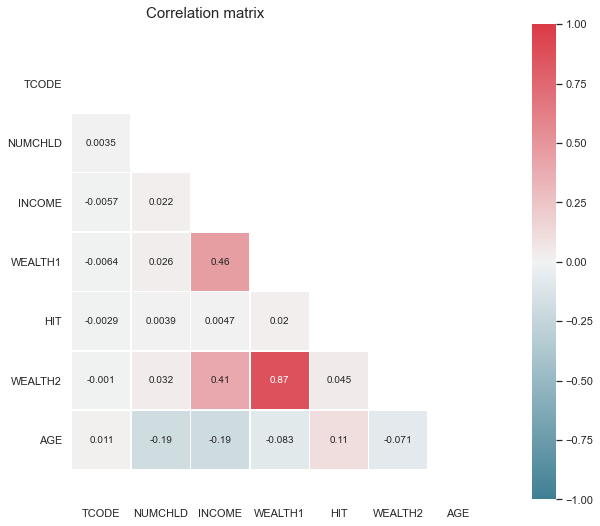

In [18]:
func.corrheatmap(df[char_feats])

There is no significant correlation except for WEALTH1 and WEALTH2

## **2.2. Interest** <a class="anchor" id="2.2"></a>

In [19]:
interests_feats = selected_features_list[selected_features_list['Category'] == 'Interests']['FeaturesName']
mail_feats = selected_features_list[selected_features_list['Category'] == 'Mail response']['FeaturesName']

### **A) Feature engineering:**

There are features containing binary information but they are not in the right data type for processing, so we convert them to binary type

In [20]:
df.loc[:, interests_feats].head()

,COLLECT1,VETERANS,BIBLE,CATLG,HOMEE,PETS,CDPLAY,STEREO,PCOWNERS,PHOTO,CRAFTS,FISHER,GARDENIN,BOATS,WALKER,KIDSTUFF,CARDS,PLATES
CONTROLN,,,,,,,,,,,,,,,,,,
95515,,,,,,,,,,,,,,,,,,
148535,,,,,,,,,,,,,,,,,,
15078,,,,,,,,,,,,,,,,,,
172556,,,,,,,,,,,,,,,,,,
7112,,,Y,Y,,,,Y,,,Y,,Y,,Y,,Y,


In [21]:
#Replace the values for booleans
df.loc[:,interests_feats] = df.loc[:,interests_feats].replace(' ',0)
df.loc[:,interests_feats] = df.loc[:,interests_feats].replace('Y',1)
df.loc[:,interests_feats].head()

,COLLECT1,VETERANS,BIBLE,CATLG,HOMEE,PETS,CDPLAY,STEREO,PCOWNERS,PHOTO,CRAFTS,FISHER,GARDENIN,BOATS,WALKER,KIDSTUFF,CARDS,PLATES
CONTROLN,,,,,,,,,,,,,,,,,,
95515,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
148535,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15078,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
172556,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7112,0,0,1,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0


### **B) Unique values check:**

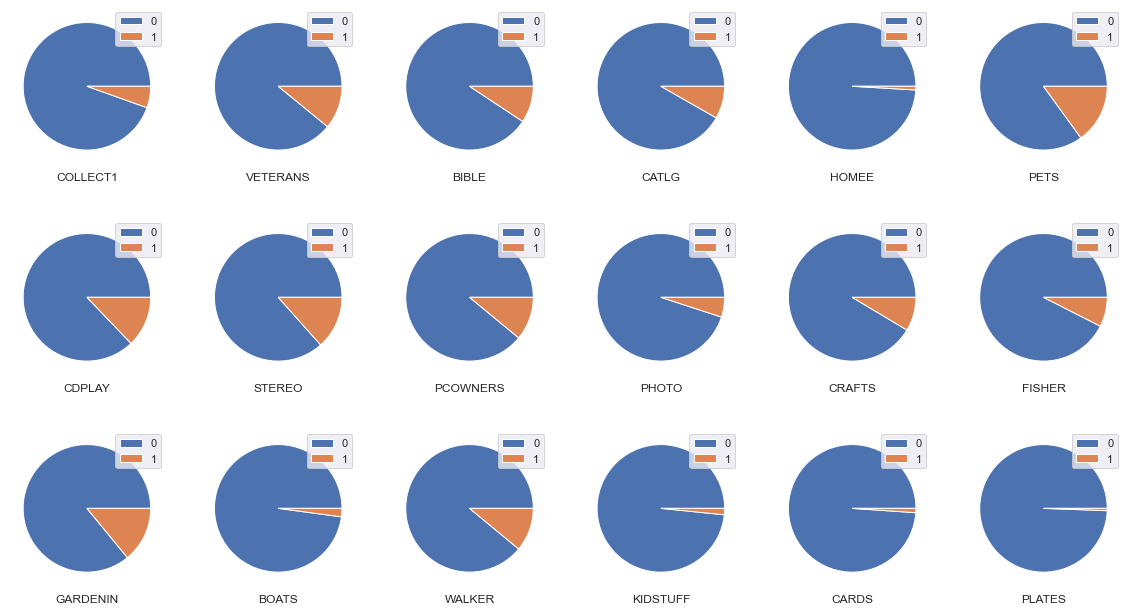

In [22]:
# Plot the result
plotdf = df.loc[:,interests_feats].apply(pd.value_counts)
#plot pie charts for all the interests
sns.set()
fig, axes = plt.subplots(3, ceil(len(plotdf.columns.to_list()) / 3), figsize=(20,11))
for ax, feat in zip(axes.flatten(), plotdf.columns.to_list()):
    ax.pie(plotdf[feat])
    ax.set_title(feat, y=-0.13)
    ax.legend(plotdf.index)
plt.show() 

## **2.3. Mail response:** <a class="anchor" id="2.3"></a>

In [23]:
mail_feats = selected_features_list[selected_features_list['Category'] == 'Mail response']['FeaturesName']

### **A) Feature engineering:**

In [24]:
df.loc[:,mail_feats]

,MBCRAFT,MBGARDEN,MBBOOKS,MBCOLECT,MAGFAML,MAGFEM,MAGMALE,PUBGARDN,PUBCULIN,PUBHLTH,PUBDOITY,PUBNEWFN,PUBPHOTO,PUBOPP
CONTROLN,,,,,,,,,,,,,,
95515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148535,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0
15078,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
172556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7112,1.0,0.0,9.0,0.0,4.0,1.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122706,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
189641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This features subset do not need any further engineering

### **B) Unique values check:**

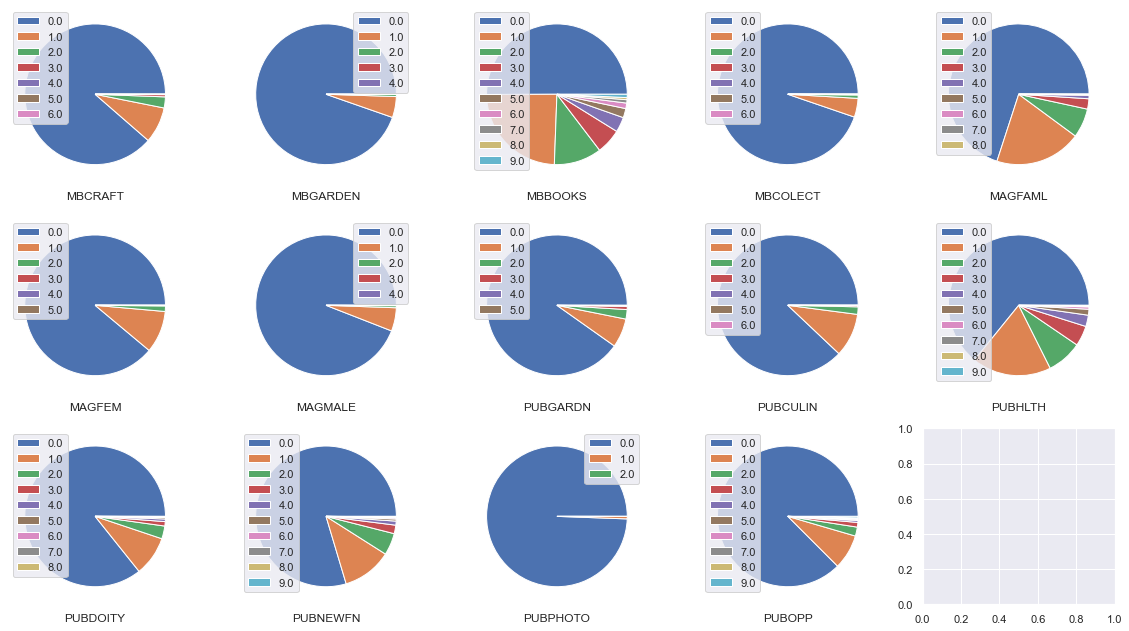

In [25]:
# Plot the result
plotdf = df.loc[:,mail_feats].apply(pd.value_counts)
#plot pie charts for all the interests
sns.set()
fig, axes = plt.subplots(3, ceil(len(plotdf.columns.to_list()) / 3), figsize=(20,11))
for ax, feat in zip(axes.flatten(), plotdf.columns.to_list()):
    ax.pie(plotdf[feat].dropna())
    ax.set_title(feat, y=-0.13)
    ax.legend(plotdf.index)
plt.show() 

### **C) Correlation check:**

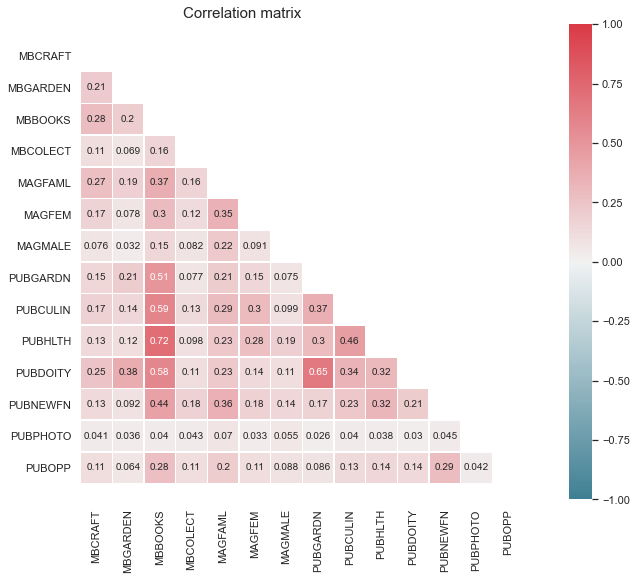

In [26]:
func.corrheatmap(df[mail_feats])

## **2.4. Neighborhood:** <a class="anchor" id="2.4"></a>

In [27]:
neighbor_feats = selected_features_list[selected_features_list['Category'] == 'Neighborhood']['FeaturesName']
# selected features
selected_features_list[selected_features_list['Category'] == 'Neighborhood']

,FeaturesName,Description,Category,Selected
54,POP901,Number of Persons,Neighborhood,x
55,POP90C1,Percent Population in Urbanized Area,Neighborhood,x
56,POP90C4,Percent Male,Neighborhood,x
57,ETH1,Percent White,Neighborhood,x
58,ETH2,Percent Black,Neighborhood,x
59,ETH3,Percent Native American,Neighborhood,x
60,ETH4,Percent Pacific Islander/Asian,Neighborhood,x
61,ETH5,Percent Hispanic,Neighborhood,x
62,ETH6,Percent Asian Indian,Neighborhood,x
63,AGE901,Median Age of Population,Neighborhood,x


### **A) Feature engineering:**

In [28]:
df[neighbor_feats].head()

,POP901,POP90C1,POP90C4,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,AGE901,...,HU3,IC2,IC5,TPE10,LFC1,OCC1,EC1,AFC1,AFC4,POBC1
CONTROLN,,,,,,,,,,,,,,,,,,,,,
95515,992,0,47,92,1,0,0,11,0,39,...,96,318,12883,14,56,9,120,0,18,3
148535,3611,99,50,67,0,0,31,6,4,34,...,97,1096,36175,24,70,22,160,0,8,42
15078,7001,0,49,96,2,0,0,2,0,35,...,93,292,11576,19,65,10,120,0,10,2
172556,640,0,54,61,0,0,11,32,6,32,...,93,388,15130,13,69,17,120,0,13,29
7112,2520,99,46,2,98,0,0,1,0,33,...,97,250,9836,24,61,17,120,1,15,1


This features subset do not need any further engineering

### **B) Unique values check:**

In [29]:
func.unique_check_numerical(df[neighbor_feats], 0.8)

['ETH6', 'AFC1']

In [30]:
func.check_value_counts(df[neighbor_feats])

POP901
0       799
1086     78
923      77
1094     75
834      73
Name: POP901, dtype: int64
-------------------
POP90C1
99    50548
0     35415
98      510
97      453
95      331
Name: POP90C1, dtype: int64
-------------------
POP90C4
49    18086
50    17284
48    14263
51    10067
47     9820
Name: POP90C4, dtype: int64
-------------------
ETH1
99    15689
98     8662
97     7133
96     6092
95     4961
Name: ETH1, dtype: int64
-------------------
ETH2
0    31240
1    18193
2     9336
3     5785
4     4068
Name: ETH2, dtype: int64
-------------------
ETH3
0    62275
1    24419
2     4306
3     1351
4      707
Name: ETH3, dtype: int64
-------------------
ETH4
0    37177
1    23722
2    10555
3     5691
4     3725
Name: ETH4, dtype: int64
-------------------
ETH5
1    22602
0    15803
2    11884
3     6999
4     4690
Name: ETH5, dtype: int64
-------------------
ETH6
0    80799
1    11412
2     1952
3      660
4      275
Name: ETH6, dtype: int64
-------------------
AGE901
33    8125
3

In [31]:
# POP901 = 0 is WEIRD. We have 799 records with 0 people in the neighborhood.

### **C) Correlation check:**

In [32]:
func.correlation_check(df[neighbor_feats],limit = 0.85)

High correlation columns are: ['IC5']


In [33]:
# After deleting some columns, we need to update the selected features list:
selected_features_list = selected_features_list.loc[selected_features_list['FeaturesName'].isin(df.columns),:]
# Get the new list of characteristics features
neighbor_feats = selected_features_list[selected_features_list['Category'] == 'Neighborhood']['FeaturesName']

## **2.5. Promotion and Gift:** <a class="anchor" id="2.5"></a>

In [34]:
PG_feats = selected_features_list[selected_features_list['Category'] == 'Promotion and Gift']['FeaturesName']
# selected features
selected_features_list[selected_features_list['Category'] == 'Promotion and Gift']

,FeaturesName,Description,Category,Selected
81,RFA_3,Donor's RFA status as of 96NK promotion date,Promotion and Gift,x
82,RFA_4,Donor's RFA status as of 96TK promotion date,Promotion and Gift,x
83,RFA_5,Donor's RFA status as of 96SK promotion date,Promotion and Gift,x
84,RFA_6,Donor's RFA status as of 96LL promotion date,Promotion and Gift,x
85,RFA_7,Donor's RFA status as of 96G1 promotion date,Promotion and Gift,x
86,RFA_8,Donor's RFA status as of 96GK promotion date,Promotion and Gift,x
87,RFA_9,Donor's RFA status as of 96CC promotion date,Promotion and Gift,x
88,RFA_10,Donor's RFA status as of 96WL promotion date,Promotion and Gift,x
89,RFA_11,Donor's RFA status as of 96X1 promotion date,Promotion and Gift,x
90,RFA_12,Donor's RFA status as of 96XK promotion date,Promotion and Gift,x


### **A) Feature engineering:**

**Generate RFA status of the each donor before they are considered to be Lapsed Donor:**

Because all the donors which is investigated in this dataset is all Lapsed Donors as the date of the lasted promotion, so we will not able to undestand the 'Recency' charateristics if we only consider the most recent code of the donor (all 'Lapsed').  

Therefore, we thought it would be interesting if we get the most recent type of code of each donor before they are considered to become Lapsed Donors

We will consider the data in features **Donor's RFA status as of XXXX promotion date (XXXX is from 'RFA_3'to 'RFA_24')**

In [35]:
# Replace the blank values with NaN value
df.loc[:,'RFA_3':'RFA_24'] = df.loc[:,'RFA_3':'RFA_24'].replace({' ' : np.NaN})
# Find the second most recent type of a donor by the left-most available values from RFA_3 to RFA_24
df['RFA_USEDTO'] = df.loc[:,'RFA_3':'RFA_24'].fillna(method = 'bfill',axis = 1)['RFA_3']
# Renerate R, F, A features
df['RFA_USEDTO_R'] = df['RFA_USEDTO'].apply(lambda x: str(x)[0])
df['RFA_USEDTO_F'] = df['RFA_USEDTO'].apply(lambda x: str(x)[1]).astype(int)
df['RFA_USEDTO_A'] = df['RFA_USEDTO'].apply(lambda x: str(x)[2])

# Add to the selected features list
feats = pd.DataFrame([['RFA_USEDTO_R', "Recency code of the previous status of the donor","Promotion and Gift","x" ],
                    ['RFA_USEDTO_F', "Frequency code of the previous status of the donor","Promotion and Gift","x"], 
                    ['RFA_USEDTO_A', "Amount code of the previous status of the donor","Promotion and Gift","x"]],
                    columns=selected_features_list.columns)
selected_features_list= selected_features_list.append(feats,ignore_index=True)

# Now drop the features that is no longer useful
df.drop(labels='RFA_USEDTO',axis=1,inplace = True, errors='ignore')
df.drop(labels=df.loc[:,'RFA_3':'RFA_24'].columns,axis=1,inplace=True,errors='ignore')

# Check for the result
df.loc[:,'RFA_USEDTO_R':'RFA_USEDTO_A'].head()

,RFA_USEDTO_R,RFA_USEDTO_F,RFA_USEDTO_A
CONTROLN,,,
95515,S,4,E
148535,A,2,G
15078,S,4,E
172556,S,4,E
7112,A,2,F


**Date-time features:**

There are 4 date-time features that we can assume that they will not have much interpretation power for clustering.  
Those features are: **'MINRDATE', 'MAXRDATE', 'NEXTDATE' and 'TIMELAG'**.  

Thus, we decided to drop them:

In [36]:
# Remove un-relevant features
df = df.drop(columns=['MINRDATE','MAXRDATE','NEXTDATE','TIMELAG'],errors='ignore')

The remaining date-time features are 'MAXADATE', 'LASTDATE' and 'FISTDATE'. These features are useful to generate two important features in RFM (Recency, Frequency and Monetary) analysis which are Recency and Frequency.  

The 2 new features to generate are:
- Time in days since the last promotion and the last gift from the donor: 'RECENCY' = 'MAXADATE' - 'LASTDATE'  
- Time in days since the last promotion and the first gift from the donor: 'LIFETIME' = 'MAXADATE' - 'FISTDATE' 

In [37]:
# convert data to datetime 
df['MAXADATE'] = pd.to_datetime(df['MAXADATE'])
df['LASTDATE'] = pd.to_datetime(df['LASTDATE'])
df['FISTDATE'] = pd.to_datetime(df['FISTDATE'])
# measure the recency and lifetime of donors
df['RECENCY'] = (df['MAXADATE'] - df['LASTDATE'])/pd.to_timedelta(1, unit='D')
df['LIFETIME'] = (df['MAXADATE'] - df['FISTDATE'])/pd.to_timedelta(1, unit='D')

# Add new features to the metadata
feats = pd.DataFrame([['RECENCY', "Time in days since the last promotion and the last gift from the donor","Promotion and Gift","x" ],
                    ['LIFETIME', "Time in days since the last promotion and the first gift from the donor","Promotion and Gift","x"]], 
                    columns=selected_features_list.columns)
selected_features_list= selected_features_list.append(feats,ignore_index=True)
                      
# Then we drop the datetime columns:
df = df.drop(columns=['MAXADATE','FISTDATE','LASTDATE'],errors='ignore')

# After deleting some columns, we need to update the selected features list:
selected_features_list = selected_features_list.loc[selected_features_list['FeaturesName'].isin(df.columns),:]
# Get the new list of characteristics features
PG_feats = selected_features_list[selected_features_list['Category'] == 'Promotion and Gift']['FeaturesName']

### **B) Unique values check:**

In [38]:
df[PG_feats].describe(include=['O'])

,RFA_2R,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,RFA_USEDTO_R,RFA_USEDTO_A
count,95412,95412,95412,95412,95412,95412,95412
unique,1,4,5,4,5,8,7
top,L,F,X,X,X,A,F
freq,95412,46964,95118,95118,95118,60156,46170


In [39]:
func.unique_check_categorical(df[PG_feats], 0.9)

RFA_2R , percentage of top unique value = 100.00 %
MDMAUD_R , percentage of top unique value = 99.69 %
MDMAUD_F , percentage of top unique value = 99.69 %
MDMAUD_A , percentage of top unique value = 99.69 %


We can clearly see that features **'RFA_2R', 'MDMAUD_R', 'MDMAUD_F' and 'MDMAUD_A'** having only 1 values for mostly all of their records, thus they are considered redundant in this cluster analysis

In [40]:
# Drop these redundant columns
df = df.drop(columns=['RFA_2R', 'MDMAUD_R', 'MDMAUD_F','MDMAUD_A'],errors='ignore')
# After deleting some columns, we need to update the selected features list:
selected_features_list = selected_features_list.loc[selected_features_list['FeaturesName'].isin(df.columns),:]
# Get the new list of characteristics features
PG_feats = selected_features_list[selected_features_list['Category'] == 'Promotion and Gift']['FeaturesName']

### **C) Correlation check:**

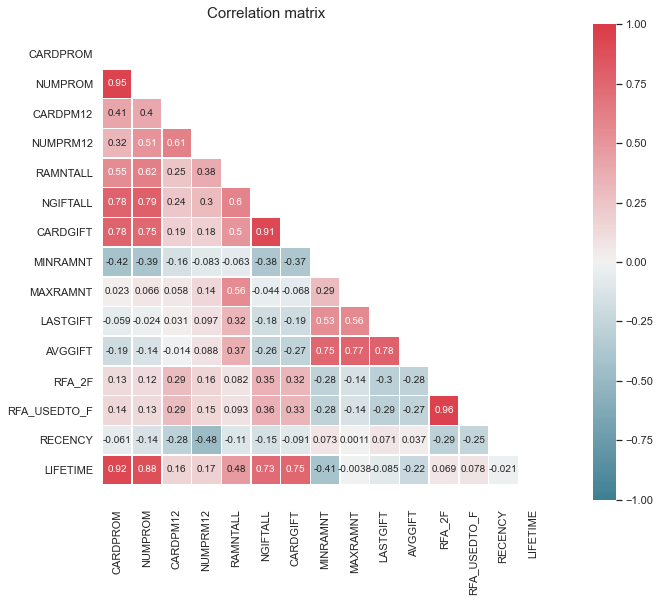

In [41]:
func.corrheatmap(df[PG_feats])

In [42]:
func.correlation_check(df[PG_feats])

High correlation columns are: ['NUMPROM', 'CARDGIFT', 'RFA_USEDTO_F', 'LIFETIME']


In [43]:
# Drop these redundant columns
df = df.drop(columns=['NUMPROM', 'CARDGIFT', 'LIFETIME'])
# After deleting some columns, we need to update the selected features list:
selected_features_list = selected_features_list.loc[selected_features_list['FeaturesName'].isin(df.columns),:]
# Get the new list of characteristics features
PG_feats = selected_features_list[selected_features_list['Category'] == 'Promotion and Gift']['FeaturesName']

### Check for data preprocessing result

In [44]:
# Current dataframe
df.head()

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,DOMAIN,HOMEOWNR,NUMCHLD,INCOME,GENDER,...,LASTGIFT,AVGGIFT,RFA_2F,RFA_2A,GEOCODE2,AGE,RFA_USEDTO_R,RFA_USEDTO_F,RFA_USEDTO_A,RECENCY
CONTROLN,,,,,,,,,,,,,,,,,,,,,
95515,2009-01-01,GRI,0,IL,61081,T2,NaN,NaN,NaN,F,...,10.0,7.741935,4,E,C,59.0,S,4,E,428.0
148535,2014-01-01,BOA,1,CA,91326,S1,H,1.0,6.0,M,...,25.0,15.666667,2,G,A,45.0,A,2,G,428.0
15078,2010-01-01,AMH,1,NC,27017,R2,U,NaN,3.0,M,...,5.0,7.481481,4,E,C,NaN,S,4,E,428.0
172556,2007-01-01,BRY,0,CA,95953,R2,U,NaN,1.0,F,...,10.0,6.812500,4,E,C,69.0,S,4,E,428.0
7112,2006-01-01,NaN,0,FL,33176,S2,H,1.0,3.0,F,...,15.0,6.864865,2,F,A,77.0,A,2,F,397.0


In [45]:
# Summary features by category
pd.DataFrame(selected_features_list.groupby('Category')['FeaturesName'].count())

,FeaturesName
Category,
Characteristics,16
Interests,18
Mail response,14
Neighborhood,27
Promotion and Gift,15


# **3. Data cleanning:** <a class="anchor" id="3"></a>

## **3.1. Outliers:** <a class="anchor" id="3.1"></a>

## **3.2. Missing values:** <a class="anchor" id="3.2"></a>

## **3.3. Data transformation:** <a class="anchor" id="3.3"></a>

## **3.4. Data transformation:** <a class="anchor" id="3.4"></a>

# **4. Clustering:** <a class="anchor" id="3"></a>